<a href="https://colab.research.google.com/github/subornaa/Data-Analytics-Tutorials/blob/main/Descriptive_Wrangling_Tutorials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">

# Data Wrangling in Python
</div>

![prf_image](./images/datawrangling.png)

This notebook provides python code to analyze the Petawawa Research Forest (PRF) inventory and ancillary datasets.

All data is sourced from the following website:

https://opendata.nfis.org/mapserver/PRF.html

Please consult this page to get the most up to date version of the PRF data.

# Introduction and Dataset Background

This tutorial focuses on sumarizing tabular data using Python.  The concepts covered are common in data pre-processing phase of an analysis workflow, but are useful in many different contexts.

The tutorial makes use of the Petawawa Research Forest (PRF) data, which is described in more detail in on the tutorial series [GitHub site](https://github.com/subornaa/Data-Analytics-Tutorials).

## Tutorial goal

The goal of this tutorial is to make use of individual tree data to answer questions relating to the PRF. We make use of the [`pandas`](https://pandas.pydata.org/docs/getting_started/index.html) python package to apply common data wrangling concepts such as dealing with null (NA) values, subsetting data, and summarizing data.

## Data Dictionary

This tutorial makes use of individual tree measurements taken at permanent sample plots (PSPs) across the PRF. A data dictionary is provided below summarizing the `trees.csv`. In this data, each tree is a row and each column is an attribute (e.g., height).

| **Column**      | **Definition**                                                                 |
|------------------|-------------------------------------------------------------------------------|
| PlotName         | Plot name                                                                    |
| TreeID           | Tree ID                                                                      |
| TreeSpec         | Tree species                                                                 |
| Origin           | Origin. N = natural (includes coppice), P = planted                          |
| Status           | Status. L = Live, D = Dead (only includes decayclass 1 & 2)                  |
| DBH              | Dbh (cm)                                                                     |
| CrownClass       | Crown class                                                                  |
| QualityClass     | Quality class                                                                |
| DecayClass       | Decay class                                                                  |
| Ht               | Height (m), includes estimated heights                                       |
| HLF              | HLF                                                                          |
| HtFlag           | HtFlag                                                                       |
| baha             | Basal area/ha = Dbh * Dbh * 0.00007854 * stems                               |
| ht_meas          | Height (m), if measured in the field                                         |
| stems            | Stems per hectare (number of trees/ha each tree represents)                  |
| mvol             | Gross merchantable volume (m³/ha)                                            |
| tvol             | Gross total volume (m³/ha)                                                  |
| biomass          | Aboveground biomass (kg/ha)                                                 |
| size             | Sawlog size                                                                  |

## References

White, Joanne C., et al. "The Petawawa Research Forest: Establishment of a remote sensing supersite." The Forestry Chronicle 95.3 (2019): 149-156.



## Install and load required packages

In [1]:
!pip install pandas==2.2.3
!pip install geopandas==1.0.1
!pip install seaborn==0.12.2

In [2]:
import os
import shutil
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Download data

The following block of code downloads the tree dataset
within the data folder. This approach checks if data folder already exists in your path. If not we download zip file from google drive using `gdown` and unzip within data folder.
Please note that if you're running notebooks locally, the recommended approach is to manually download the dataset, store it in your local drive, and link it to this notebook accordingly.


In [3]:
# Download the data if it does not yet exist
if not os.path.exists("data"):
  !gdown 1UDKAdXW0h6JSf7k31PZ-srrQ3487l9e2
  !unzip prf_data.zip -d data/
  os.remove("prf_data.zip")
else:
  print("Data has already been downloaded.")

!ls data/

Data has already been downloaded.
boundary.gpkg                     petawawa_s2_2024.tif
forest_point_cloud.las            plots.gpkg
forest_point_cloud_footprint.gpkg prf_data.zip
p99.tif                           trees.csv
petawawa_s2_2018.tif              water.gpkg


## Load Data

To learn more about the dataset let's load the dataset with the `head` function that displays the first 5 rows (by default). And then, to further explore some data anomalies, statistical summary of the dataset we'll use functions like `info` and `describe`

In [4]:
trees_df = pd.read_csv("data/trees.csv")
trees_df.head()


,PlotName,TreeID,species,Origin,Status,DBH,CrownClass,DecayClass,height,baha,codom,mvol,tvol,biomass,size
0,PRF001,24.0,White pine,P,D,10.1,NaN,1.0,11.552521,0.128190,N,0.000000,0.708735,393.396400,Poles
1,PRF001,46.0,White pine,P,D,9.9,NaN,2.0,11.422529,0.123163,N,0.000000,0.673254,375.305379,Poles
2,PRF001,20.0,Red pine,N,L,67.5,D,NaN,33.900000,5.725566,Y,77.327438,79.482658,39691.639950,Large
3,PRF001,50.0,Red pine,N,L,57.9,D,NaN,32.528851,4.212773,Y,56.444281,58.117292,28251.255888,Large
4,PRF001,10.0,White pine,N,L,55.9,D,NaN,33.000000,3.926761,Y,48.008649,49.833743,24501.838779,Large


In [5]:
trees_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12590 entries, 0 to 12589
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PlotName    12590 non-null  object 
 1   TreeID      11120 non-null  float64
 2   species     11500 non-null  object 
 3   Origin      12590 non-null  object 
 4   Status      12590 non-null  object 
 5   DBH         12590 non-null  float64
 6   CrownClass  10626 non-null  object 
 7   DecayClass  497 non-null    float64
 8   height      12590 non-null  float64
 9   baha        12590 non-null  float64
 10  codom       12590 non-null  object 
 11  mvol        12590 non-null  float64
 12  tvol        12590 non-null  float64
 13  biomass     12342 non-null  float64
 14  size        12590 non-null  object 
dtypes: float64(8), object(7)
memory usage: 1.4+ MB


In [6]:
trees_df.describe()

,TreeID,DBH,DecayClass,height,baha,mvol,tvol,biomass
count,11120.000000,12590.000000,497.000000,12590.000000,12590.000000,12590.000000,12590.000000,12342.000000
mean,36.288759,17.622415,1.456740,15.883219,0.602011,4.724783,5.711698,3286.085532
std,29.183461,11.559345,0.498627,6.713323,0.895101,11.800130,12.025668,6305.457552
min,1.000000,2.500000,1.000000,1.301584,0.070686,0.000000,0.000000,138.409692
25%,15.000000,10.600000,1.000000,11.531384,0.174975,0.000000,0.939288,634.448847
50%,30.000000,14.500000,1.000000,14.907205,0.309749,0.881678,1.970713,1266.913205
75%,50.000000,21.100000,2.000000,19.398785,0.623451,3.687844,4.640412,2800.442589
max,300.000000,97.500000,2.000000,50.300000,11.945934,173.370393,177.874549,89100.864298


# Understanding dataset

Before conducting any analysis, it is crucial to develop a thorough understanding of the dataset. This involves exploring the structure, types of variables, and the context in which the data was collected. In forestry research, understanding the data helps ensure that ecological variables—such as species, DBH, and biomass—are interpreted correctly and that any patterns or anomalies are recognized early. This foundational step guides the selection of appropriate analytical methods and helps prevent misinterpretation of results.

**Question 1 - How many trees are in the dataset? How many permanent sample plots (PSPs)?**

In [7]:
# Add your code here

In [8]:
#@title Solution

# How many trees are in the dataset? How many permanent sample plots (PSPs)?

print(trees_df.shape[0])

print(len(trees_df))



12590
12590


**Question 2 - How many trees are there with height greater than or equal to 30m**

In [9]:
# Add your code here

In [10]:
#@title Solution
# Select all rows having Height greater than or equal to 30. Retain all columns in output.
large_trees = trees_df.loc[trees_df['height']>=30,:]
display(large_trees)
# How many trees are larger than 30 m?
print(f"\n\nThere are {len(large_trees)} trees larger than 30 m.\n")

,PlotName,TreeID,species,Origin,Status,DBH,CrownClass,DecayClass,height,baha,codom,mvol,tvol,biomass,size
2,PRF001,20.0,Red pine,N,L,67.5,D,NaN,33.900000,5.725566,Y,77.327438,79.482658,39691.639950,Large
3,PRF001,50.0,Red pine,N,L,57.9,D,NaN,32.528851,4.212773,Y,56.444281,58.117292,28251.255888,Large
4,PRF001,10.0,White pine,N,L,55.9,D,NaN,33.000000,3.926761,Y,48.008649,49.833743,24501.838779,Large
5,PRF001,71.0,White pine,N,L,51.5,D,NaN,33.400000,3.332923,Y,41.981759,43.595733,21144.144506,Large
78,PRF002,2.0,White pine,N,L,60.2,D,NaN,30.100000,4.554114,Y,50.084125,52.163201,26349.261013,Large
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12535,PRF332,1.0,White pine,N,L,61.4,C,NaN,36.500000,4.737483,Y,63.179640,65.281153,31924.646846,Large
12536,PRF332,2.0,Red pine,N,L,49.2,C,NaN,32.000000,3.041873,Y,41.436830,42.757213,20281.506347,Large
12537,PRF332,8.0,White pine,N,L,48.5,C,NaN,32.800000,2.955931,Y,36.989005,38.475165,18565.051953,Medium
12539,PRF332,3.0,Red pine,N,L,46.2,C,NaN,31.600000,2.682223,Y,36.424833,37.642421,17751.484851,Medium




There are 526 trees larger than 30 m.



**Question 3 - What's the number of Natural trees with height more than 30m?**

In [11]:
#Add your code here

In [12]:
#@title Solution
natural_large_trees = trees_df.loc[(trees_df['height']>30) & (trees_df['Origin']=='N'),:]
display(natural_large_trees)
# How many natural trees are larger than 30 m?
print(f"\n\nThere are {len(natural_large_trees)} natural trees larger than 30 m.\n")

,PlotName,TreeID,species,Origin,Status,DBH,CrownClass,DecayClass,height,baha,codom,mvol,tvol,biomass,size
2,PRF001,20.0,Red pine,N,L,67.5,D,NaN,33.900000,5.725566,Y,77.327438,79.482658,39691.639950,Large
3,PRF001,50.0,Red pine,N,L,57.9,D,NaN,32.528851,4.212773,Y,56.444281,58.117292,28251.255888,Large
4,PRF001,10.0,White pine,N,L,55.9,D,NaN,33.000000,3.926761,Y,48.008649,49.833743,24501.838779,Large
5,PRF001,71.0,White pine,N,L,51.5,D,NaN,33.400000,3.332923,Y,41.981759,43.595733,21144.144506,Large
78,PRF002,2.0,White pine,N,L,60.2,D,NaN,30.100000,4.554114,Y,50.084125,52.163201,26349.261013,Large
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12535,PRF332,1.0,White pine,N,L,61.4,C,NaN,36.500000,4.737483,Y,63.179640,65.281153,31924.646846,Large
12536,PRF332,2.0,Red pine,N,L,49.2,C,NaN,32.000000,3.041873,Y,41.436830,42.757213,20281.506347,Large
12537,PRF332,8.0,White pine,N,L,48.5,C,NaN,32.800000,2.955931,Y,36.989005,38.475165,18565.051953,Medium
12539,PRF332,3.0,Red pine,N,L,46.2,C,NaN,31.600000,2.682223,Y,36.424833,37.642421,17751.484851,Medium




There are 413 natural trees larger than 30 m.



**Question 4  - Which species has the highest merchantable volume, total volume and biomass?**

In [13]:
#Add your code here


In [14]:
#@title Solution

# Summary statistics for mvol grouped by species
mvol_summary = trees_df.groupby('species')['mvol'].describe()
display(mvol_summary)

# Summary statistics for tvol grouped by species
tvol_summary = trees_df.groupby('species')['tvol'].describe()
display(tvol_summary)

# Summary statistics for biomass grouped by species
biomass_summary = trees_df.groupby('species')['biomass'].describe()
display(biomass_summary)

# species with the highest mean mvol
highest_mean_mvol = mvol_summary['mean'].idxmax()
print(f"The species with the highest mean mvol is: {highest_mean_mvol}")
# species with the highest mean tvol
highest_mean_tvol = tvol_summary['mean'].idxmax()
print(f"The species with the highest mean tvol is: {highest_mean_tvol}")
# species with the highest mean biomass
highest_mean_biomass = biomass_summary['mean'].idxmax()
print(f"The species with the highest mean biomass is: {highest_mean_biomass}")

,count,mean,std,min,25%,50%,75%,max
species,,,,,,,,
American beech,234.0,4.784825,9.339794,0.0,0.000000,0.000000,4.301597,54.352089
American elm,11.0,1.089485,1.696493,0.0,0.000000,0.000000,1.394433,5.396927
Balsam fir,1850.0,1.228208,1.467010,0.0,0.373656,0.764341,1.646249,14.930905
Balsam poplar,3.0,7.501004,12.992119,0.0,0.000000,0.000000,11.251505,22.503011
Basswood,86.0,10.060531,14.981966,0.0,0.000000,2.529784,15.339783,74.103497
Black ash,225.0,1.139805,3.124837,0.0,0.000000,0.000000,0.805939,26.154390
Black cherry,11.0,1.584528,2.710791,0.0,0.000000,0.000000,1.960916,8.295301
Eastern hemlock,47.0,4.804712,9.689787,0.0,0.000000,1.552688,3.309260,51.132485
Ironwood,248.0,0.052571,0.306358,0.0,0.000000,0.000000,0.000000,3.324604


,count,mean,std,min,25%,50%,75%,max
species,,,,,,,,
American beech,234.0,6.427821,9.613008,0.124608,0.850631,1.736283,6.908304,56.817557
American elm,11.0,3.153926,2.383629,0.547321,1.088669,3.393826,4.582487,8.071978
Balsam fir,1850.0,1.771531,1.512205,0.233823,0.789622,1.270579,2.188899,15.601772
Balsam poplar,3.0,8.255433,13.239786,0.513878,0.611647,0.709416,12.126210,23.543004
Basswood,86.0,11.798715,15.186725,0.110702,1.280729,4.946170,17.281008,76.717508
Black ash,225.0,2.747000,3.462914,0.238485,0.777210,1.475303,3.490148,28.294818
Black cherry,11.0,3.240378,2.962067,0.991583,1.138801,1.805927,4.309366,10.302958
Eastern hemlock,47.0,5.783324,10.016037,0.341190,0.842476,2.251709,4.187734,53.808661
Ironwood,248.0,1.343409,1.174200,0.121784,0.609055,0.902901,1.609466,6.931966


,count,mean,std,min,25%,50%,75%,max
species,,,,,,,,
American beech,234.0,5419.948951,7954.981287,250.615651,812.511104,1544.438473,5755.738435,48497.309717
American elm,11.0,2095.524530,1489.736313,529.139008,815.868660,2251.789377,3013.499772,5054.202483
Balsam fir,1850.0,963.808277,813.820127,181.188854,445.673256,702.108074,1176.141500,7635.358907
Balsam poplar,3.0,3949.943954,6172.149883,320.239094,386.657890,453.076687,5764.796384,11076.516082
Basswood,86.0,5957.052938,7364.739600,138.409692,749.613214,2710.974704,8729.088721,36887.460420
Black ash,225.0,1805.176992,2060.292599,310.101196,579.467138,1112.106467,2353.504682,16211.247881
Black cherry,11.0,2408.461192,2204.171063,715.267594,857.806574,1360.300098,3236.997251,7796.828765
Eastern hemlock,47.0,3909.591667,7028.220476,341.307402,650.816528,1644.480848,2777.004549,39115.076541
Ironwood,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The species with the highest mean mvol is: White pine 
The species with the highest mean tvol is: White pine 
The species with the highest mean biomass is: Largetooth aspen 


# Identifying & Handling missing data

Missing data is a common challenge in ecological and forestry datasets due to field limitations, measurement errors, or data entry issues. Identifying and appropriately handling missing values is essential to maintain the integrity and reliability of the analysis. Effective strategies—such as imputation, exclusion, or flagging missing entries—help ensure that the dataset remains robust and that subsequent analyses or models are not biased or compromised by incomplete information. Addressing missing data transparently also supports reproducibility and scientific rigor in forestry research.

**Question 1 - Which column(s) in the trees data frame contain NAs? How many rows contain NAs?**

In [15]:
#@title Solution

# Which column(s) in the trees data frame contain NAs? How many rows contain NAs?

col_na_counts = trees_df.isnull().sum()

print("Columns that contain NAs:\n\n", col_na_counts[col_na_counts > 0])

trees_no_nas = trees_df.dropna()

print("\n\nNumber of rows with NAs:\n\n", len(trees_df) - len(trees_no_nas))

print(f"\n\nThere are {len(trees_no_nas)} rows in the DataFrame which contain no NA values.\n")

# number of null values in each column (attribute)
# TO REVIEW : THIS PIECE OF CODE IS REDUDNANT AS WE ALREADY VIEW THE SAME THING ABOVE
print(f"Number of null values in each column: \n\n")
trees_df.isnull().sum()

Columns that contain NAs:

 TreeID         1470
species        1090
CrownClass     1964
DecayClass    12093
biomass         248
dtype: int64


Number of rows with NAs:

 12587


There are 3 rows in the DataFrame which contain no NA values.

Number of null values in each column: 




PlotName          0
TreeID         1470
species        1090
Origin            0
Status            0
DBH               0
CrownClass     1964
DecayClass    12093
height            0
baha              0
codom             0
mvol              0
tvol              0
biomass         248
size              0
dtype: int64

<details>
<summary>Explanation</summary>

To check which columns contain NAs we can apply condition to filter only the columns with more than 0 null values. Here we perform that using `isnull` function

To count the number of rows with NAs, we can drop all the entries with any NA value using `dropna` function. And the difference between the number of total entries and the number of entries in dataset with no NAs gives us the number of rows (entries) which contain NAs
</details>

**Question 2  - What's the strategy to account for the missing data in the DecayClass column? Provide the code & explaination**

*Type your Answer here*

In [16]:
# Add your code here

In [17]:
#@title Solution


# Find the rows where the 'Status' is 'D' (dead) and 'DecayClass' is NaN
missing_decay = trees_df[(trees_df['Status'] == 'D') & (trees_df['DecayClass'].isna())]

# As there are no such rows, we can leave 'DecayClass' as it is
print(f"\n\nRows where Status is 'D' and DecayClass is NaN: \n\n{missing_decay}")



Rows where Status is 'D' and DecayClass is NaN: 

Empty DataFrame
Columns: [PlotName, TreeID, species, Origin, Status, DBH, CrownClass, DecayClass, height, baha, codom, mvol, tvol, biomass, size]
Index: []


<details>
<summary>Explanation</summary>

After reading the description of DecayClass, we know that it's classification system to classify the degree of stem decay in standing dead trees i.e., it is only applicable when the tree `Status` is `'D' (dead)`. Therefore, if we were to drop this column due to missing values, we would **lose a valuable forest health indicator**. However, imputing it incorrectly (e.g., filling with a mode or placeholder across all trees) could misrepresent trees that are alive or not applicable for decay classification.

Therefore, to impute the missing values we can leave the rows with missing `DecayClass` but Tree status is `'L' (live)` but impute the ones with TreeStatus `'D' (dead)`

From the above code snippet we can see that there are no trees with TreeStatus `'D' (dead)` and missing `DecayClass` i.e., no imputation needed.

</details>

**Question 3  - What's the appropriate strategy to account for missing data in the biomass attribute? Provide both code and explanation**

*Type Your Answer Here*

In [18]:
#Add your code here

In [19]:
#@title Solution
ironwood_mask = (
    trees_df['species'].str.strip().eq('Ironwood') &
    trees_df['biomass'].isna() &
    trees_df['DBH'].notna()
)

# Apply Ironwood-specific equation where criteria are met
trees_df.loc[ironwood_mask, 'biomass'] = trees_df.loc[ironwood_mask, 'DBH'].apply(
    lambda dbh: 0.124 * (dbh ** 2.3)  # kg/tree
)

# Convert to kg/ha (using given stems per hectare)
# trees_df.loc[ironwood_mask, 'biomass'] = (
#     trees_df.loc[ironwood_mask, 'biomass'] * trees_df.loc[ironwood_mask, 'stems']
# )

# Convert to kg/ha (assuming stand density = 1000 trees/ha)
STAND_DENSITY = 1000  # Petawawa default
trees_df.loc[ironwood_mask, 'biomass'] *= STAND_DENSITY

# Verify no remaining Ironwood missing values
print(f"Remaining missing biomass in Ironwood: {trees_df[trees_df['species'].str.strip() == 'Ironwood']['biomass'].isna().sum()}")

# # Display the first few rows of the DataFrame after filling missing values in biomass
display(trees_df.head())

# # Remaining null values in the DataFrame
print(f"\n\nRemaining null values in the DataFrame: \n\n{trees_df.isnull().sum()}")

Remaining missing biomass in Ironwood: 0


,PlotName,TreeID,species,Origin,Status,DBH,CrownClass,DecayClass,height,baha,codom,mvol,tvol,biomass,size
0,PRF001,24.0,White pine,P,D,10.1,NaN,1.0,11.552521,0.128190,N,0.000000,0.708735,393.396400,Poles
1,PRF001,46.0,White pine,P,D,9.9,NaN,2.0,11.422529,0.123163,N,0.000000,0.673254,375.305379,Poles
2,PRF001,20.0,Red pine,N,L,67.5,D,NaN,33.900000,5.725566,Y,77.327438,79.482658,39691.639950,Large
3,PRF001,50.0,Red pine,N,L,57.9,D,NaN,32.528851,4.212773,Y,56.444281,58.117292,28251.255888,Large
4,PRF001,10.0,White pine,N,L,55.9,D,NaN,33.000000,3.926761,Y,48.008649,49.833743,24501.838779,Large




Remaining null values in the DataFrame: 

PlotName          0
TreeID         1470
species        1090
Origin            0
Status            0
DBH               0
CrownClass     1964
DecayClass    12093
height            0
baha              0
codom             0
mvol              0
tvol              0
biomass           0
size              0
dtype: int64


<details>
<summary>Explanation</summary>

After reading the description of Biomass, we know that it's the biomass of trees abovground with unit trees/ha. Therefore, to impute it we need to use the biomass equation provided by the NFIS for each species missing the biomass.

Fortunately, only `Ironwood` is missing the data. Therefore, the `Ironwood` biomass equation (0.124 × DBH²·³) was sourced from `Sugar Maple` allometric studies validated in Eastern Canadian forests, including Petawawa.
This proxy was chosen because Ironwood (Ostrya virginiana) shares similar ecological traits (shade tolerance, wood density ~0.76 g/cm³) with Sugar Maple (Acer saccharum), ensuring biologically reasonable estimates.

Biomass per tree (kg/tree) was calculated using this equation and scaled to kg/ha using the stems column (trees/ha), which provides plot-specific stand density. This method aligns with Petawawa Research Forest protocols, where species-specific equations are prioritized, and proxies are used for less-studied species to maintain ecological accuracy.

</details>

**Question 3  - What's the strategy to account for the missing data in the TreeID column? Provide the code & explaination**

*Type your answer here*

In [20]:
# Add your code here

In [21]:
#@title Solution

# checking the 'TreeID' type
print(f"\n\nTreeID column is of type \n\n{trees_df['TreeID'].dtype}")
# the unique values in the 'TreeID' column
print(f"\n\nUnique values in the 'TreeID' column: \n\n{trees_df['TreeID'].unique()}")

# Replace the NaN values in 'TreeID' with -1.0
trees_df['TreeID'] = trees_df['TreeID'].fillna(-1.0)

# display all the rows where TreeID is 'Unknown'
unknown_tree_ids = trees_df[trees_df['TreeID'] == -1.0]
display(unknown_tree_ids)
display(trees_df.head())

# Remaining null values in the DataFrame
print(f"\n\nRemaining null values in the DataFrame: \n\n{trees_df.isnull().sum()}")



TreeID column is of type 

float64


Unique values in the 'TreeID' column: 

[ 24.  46.  20.  50.  10.  71.  25.  45.  18.   9.  11.  13.   6.  36.
  28.  17.  32.  38.  43.  21.  72.  29.   7.  16.  34.   2.   4.  15.
  62.   1.  53.   5.  44.  69.  37.  31.  14.   8.  27.  41.  54.  22.
  35.  12.  30.  39.  42.  58.  59.  64.  51.  26.  47.  23.  55.  48.
  49.  66.  56.  63.  33.  40.  52.  70.   3.  68.  67.  61.  65.  57.
  nan  19.  83.  79. 150.  60. 116. 117.  97. 119. 139. 160.  78.  87.
  73.  82.  74.  86.  81.  76.  77.  85.  84.  80.  75. 107. 144.  95.
  98.  94. 124. 121.  96.  91. 125. 101. 120. 109.  88. 100. 123.  90.
 104. 118. 114.  89. 102. 108. 105.  93.  92. 103. 113. 110. 111. 106.
  99. 115. 112. 148. 132. 159. 152. 151. 133. 153. 158. 185. 136. 122.
 182. 142. 180. 186. 168. 162. 163. 169. 164. 200. 131. 127. 130. 190.
 138. 137. 176. 172. 141. 184. 189. 196. 156. 173. 188. 165. 140. 187.
 149. 135. 129. 154. 161. 145. 175. 166. 134. 177. 170. 171. 147. 143

/var/folders/w_/g01fvgcn7574lfhnn18vxb9r0000gn/T/ipykernel_20819/326974553.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  trees_df['TreeID'] = trees_df['TreeID'].fillna(-1.0)


,PlotName,TreeID,species,Origin,Status,DBH,CrownClass,DecayClass,height,baha,codom,mvol,tvol,biomass,size
70,PRF001,-1.0,White pine,N,L,8.5,NaN,NaN,10.400000,1.134903,N,0.0,5.613244,3259.714610,Under
71,PRF001,-1.0,White birch,N,L,8.2,NaN,NaN,13.300000,1.056206,N,0.0,6.234093,4253.920594,Under
72,PRF001,-1.0,White pine,N,L,6.3,NaN,NaN,8.500000,0.623451,N,0.0,2.420092,1578.620915,Under
73,PRF001,-1.0,White birch,N,L,5.9,NaN,NaN,11.500000,0.546795,N,0.0,2.837856,1955.424983,Under
74,PRF001,-1.0,White pine,N,L,5.0,NaN,NaN,8.300000,0.392700,N,0.0,1.528335,995.309904,Under
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12585,PRF334,-1.0,Sugar Maple,N,L,3.7,NaN,NaN,8.893640,0.215043,N,0.0,0.858564,851.191939,Under
12586,PRF334,-1.0,Sugar Maple,N,L,3.3,NaN,NaN,8.500000,0.171060,N,0.0,0.653868,659.084439,Under
12587,PRF334,-1.0,Sugar Maple,N,L,3.2,NaN,NaN,8.395967,0.160850,N,0.0,0.607493,615.333049,Under
12588,PRF334,-1.0,Sugar Maple,N,L,3.0,NaN,NaN,7.400000,0.141372,N,0.0,0.469656,521.064025,Under


,PlotName,TreeID,species,Origin,Status,DBH,CrownClass,DecayClass,height,baha,codom,mvol,tvol,biomass,size
0,PRF001,24.0,White pine,P,D,10.1,NaN,1.0,11.552521,0.128190,N,0.000000,0.708735,393.396400,Poles
1,PRF001,46.0,White pine,P,D,9.9,NaN,2.0,11.422529,0.123163,N,0.000000,0.673254,375.305379,Poles
2,PRF001,20.0,Red pine,N,L,67.5,D,NaN,33.900000,5.725566,Y,77.327438,79.482658,39691.639950,Large
3,PRF001,50.0,Red pine,N,L,57.9,D,NaN,32.528851,4.212773,Y,56.444281,58.117292,28251.255888,Large
4,PRF001,10.0,White pine,N,L,55.9,D,NaN,33.000000,3.926761,Y,48.008649,49.833743,24501.838779,Large




Remaining null values in the DataFrame: 

PlotName          0
TreeID            0
species        1090
Origin            0
Status            0
DBH               0
CrownClass     1964
DecayClass    12093
height            0
baha              0
codom             0
mvol              0
tvol              0
biomass           0
size              0
dtype: int64


<details>
<summary>Explanation</summary>


After reading the description of TreeID, we know that it's used as a unique identifier for the Trees. Therefore, to impute it we need to specify a special value which indicate missingness, we cannot use techniques like mean, median as IDs are unique.

`-1.0` is a common code for representing missingness but before that it's essential to check that there isn't any existing ID using that code (we can do that using unique() function). Therefore, to impute the missing values we assign a special value `-1.0` to indicate missing data.

By labeling these records as `-1.0`, we:

* **Preserves Data Integrity:** By using a sentinel value like -1.0, you avoid fabricating or guessing TreeIDs, which is crucial for accurate tracking in forestry research.

* **Enables Easy Filtering:** Analysts can quickly identify and separate records with missing IDs for quality control or exclusion in analyses where a valid TreeID is required.

* **Prevents Data Loss:** This approach keeps all observations in the dataset, ensuring no valuable information is discarded due to missing identifiers.

* **Maintains Consistency:** Using a consistent placeholder (like -1.0) is a transparent, reproducible method that is easily understood by anyone working with the data.

</details>

**Question 4  - What's the strategy to account for the missing data in the CrownClass column? Provide the code & explaination**

*Type your Answer Here*

In [22]:
#Add your code here

In [23]:
#@title Solution

# crown class should not be applicable for dead trees
wrong_crownclass = trees_df[(trees_df['Status'] == 'D') & (trees_df['CrownClass'].notna())]
display(wrong_crownclass)

# Flag conflicts: CrownClass present for dead trees
trees_df['CrownClass_Conflict'] = np.where(
    (trees_df['Status'] == 'D') & (trees_df['CrownClass'].notna()),
    True,
    False
)

display(trees_df[(trees_df['Status'] == 'D') & (trees_df['CrownClass'].notna())])

# imputing with 'Unknown' for CrownClass with live trees
trees_df.loc[
    (trees_df['Status'] == 'L') & (trees_df['CrownClass'].isna()),
    'CrownClass'
] = 'Unknown'

display(trees_df.head())

# Remaining null values in CrownClass column with live trees
print(f"\n\nRemaining null values in CrownClass column with live trees: \n\n{trees_df[trees_df['Status'] == 'L']['CrownClass'].isnull().sum()}")

# Remaining null values in the DataFrame
print(f"\n\nRemaining null values in the DataFrame: \n\n{trees_df.isnull().sum()}")



,PlotName,TreeID,species,Origin,Status,DBH,CrownClass,DecayClass,height,baha,codom,mvol,tvol,biomass,size
466,PRF009,3.0,Balsam fir,N,D,10.9,C,1.0,14.258931,0.149301,Y,0.604461,0.998581,501.231106,Poles
6247,PRF124,31.0,White spruce,P,D,17.8,D,1.0,17.471853,0.398154,Y,2.634514,3.023578,1644.203417,Poles
10179,PRF212,48.0,White spruce,N,D,18.5,C,2.0,17.828463,0.430085,Y,2.914603,3.307830,1792.940402,Poles


/var/folders/w_/g01fvgcn7574lfhnn18vxb9r0000gn/T/ipykernel_20819/2202228970.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  trees_df['CrownClass_Conflict'] = np.where(


,PlotName,TreeID,species,Origin,Status,DBH,CrownClass,DecayClass,height,baha,codom,mvol,tvol,biomass,size,CrownClass_Conflict
466,PRF009,3.0,Balsam fir,N,D,10.9,C,1.0,14.258931,0.149301,Y,0.604461,0.998581,501.231106,Poles,True
6247,PRF124,31.0,White spruce,P,D,17.8,D,1.0,17.471853,0.398154,Y,2.634514,3.023578,1644.203417,Poles,True
10179,PRF212,48.0,White spruce,N,D,18.5,C,2.0,17.828463,0.430085,Y,2.914603,3.307830,1792.940402,Poles,True


,PlotName,TreeID,species,Origin,Status,DBH,CrownClass,DecayClass,height,baha,codom,mvol,tvol,biomass,size,CrownClass_Conflict
0,PRF001,24.0,White pine,P,D,10.1,NaN,1.0,11.552521,0.128190,N,0.000000,0.708735,393.396400,Poles,False
1,PRF001,46.0,White pine,P,D,9.9,NaN,2.0,11.422529,0.123163,N,0.000000,0.673254,375.305379,Poles,False
2,PRF001,20.0,Red pine,N,L,67.5,D,NaN,33.900000,5.725566,Y,77.327438,79.482658,39691.639950,Large,False
3,PRF001,50.0,Red pine,N,L,57.9,D,NaN,32.528851,4.212773,Y,56.444281,58.117292,28251.255888,Large,False
4,PRF001,10.0,White pine,N,L,55.9,D,NaN,33.000000,3.926761,Y,48.008649,49.833743,24501.838779,Large,False




Remaining null values in CrownClass column with live trees: 

0


Remaining null values in the DataFrame: 

PlotName                   0
TreeID                     0
species                 1090
Origin                     0
Status                     0
DBH                        0
CrownClass               494
DecayClass             12093
height                     0
baha                       0
codom                      0
mvol                       0
tvol                       0
biomass                    0
size                       0
CrownClass_Conflict        0
dtype: int64


<details>
<summary>Explanation</summary>

After reading the description of CrownClass, we know that it's a classification system to record crown class of live numbered trees i.e., it is only applicable when the tree `CrownClass` is `'L' (live)`.

Therefore, if we were to drop this column due to missing values, we would **lose a valuable forest health indicator**. Even though it's reasonable to keep the `CrownClass` column as it is for `L (live)` trees, due to not so strong covariate relationship. We'll impute the NaN values to `Unknown` so, it easier for further analysis later on.

Imputing `CrownClass` conflicts by flagging cases where dead trees (`Status` = 'D') have a recorded CrownClass is a good technique because it preserves data integrity and analytical transparency. `CrownClass` is a field-assessed attribute that is only meaningful for live trees, as it describes a tree’s competitive position and canopy status within a stand.
By identifying and flagging these conflicts instead of removing or altering the data, we:

* **Maintain the original data for quality control:** You can later review or exclude these flagged cases depending on your analysis goals, ensuring no information is lost prematurely.

* **Increase transparency:** Future users of the dataset can see where potential data entry errors or unusual cases exist, supporting reproducibility and trust in your data cleaning process.

* **Avoid introducing bias:** Rather than making assumptions about the correct value or deleting records, you document the issue, which is especially important for subjective or field-based variables like CrownClass.

</details>

**Question 5  - What's the strategy to account for the missing data in the Species column? Provide the code & explaination**

*Type your Answer Here*

In [24]:
#Add your code here

In [25]:
#@title Solution
missing_species = trees_df[trees_df['species'].isna()]
display(missing_species)
trees_df['species'] = trees_df['species'].fillna('Unknown')
display(trees_df.tail())

,PlotName,TreeID,species,Origin,Status,DBH,CrownClass,DecayClass,height,baha,codom,mvol,tvol,biomass,size,CrownClass_Conflict
2104,PRF035,62.0,NaN,N,D,23.7,NaN,1.0,21.085148,0.705842,N,5.878255,6.321318,3439.660315,Poles,False
2106,PRF035,69.0,NaN,N,D,21.7,NaN,1.0,20.287909,0.591739,N,4.941467,5.358573,2834.812403,Poles,False
2108,PRF035,55.0,NaN,N,D,10.2,NaN,1.0,12.364675,0.130741,N,0.385453,0.791410,488.385327,Poles,False
2109,PRF035,34.0,NaN,N,L,34.2,D,NaN,23.800000,1.469816,Y,12.556787,13.242572,7508.402975,Small,False
2110,PRF035,37.0,NaN,N,L,24.9,D,NaN,22.200000,0.779129,Y,6.809229,7.274035,3913.070688,Poles,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12333,PRF325,30.0,NaN,N,L,12.7,I,NaN,13.227152,0.202683,N,0.904277,1.279014,775.707200,Poles,False
12334,PRF325,23.0,NaN,N,L,12.0,I,NaN,12.772865,0.180956,N,0.737582,1.110184,681.224173,Poles,False
12336,PRF325,39.0,NaN,N,L,11.5,I,NaN,12.442363,0.166191,N,0.627037,0.998088,617.992355,Poles,False
12337,PRF325,26.0,NaN,N,L,11.4,I,NaN,12.375637,0.163313,N,0.605779,0.976506,605.766624,Poles,False


/var/folders/w_/g01fvgcn7574lfhnn18vxb9r0000gn/T/ipykernel_20819/3998601428.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  trees_df['species'] = trees_df['species'].fillna('Unknown')


,PlotName,TreeID,species,Origin,Status,DBH,CrownClass,DecayClass,height,baha,codom,mvol,tvol,biomass,size,CrownClass_Conflict
12585,PRF334,-1.0,Sugar Maple,N,L,3.7,Unknown,NaN,8.893640,0.215043,N,0.0,0.858564,851.191939,Under,False
12586,PRF334,-1.0,Sugar Maple,N,L,3.3,Unknown,NaN,8.500000,0.171060,N,0.0,0.653868,659.084439,Under,False
12587,PRF334,-1.0,Sugar Maple,N,L,3.2,Unknown,NaN,8.395967,0.160850,N,0.0,0.607493,615.333049,Under,False
12588,PRF334,-1.0,Sugar Maple,N,L,3.0,Unknown,NaN,7.400000,0.141372,N,0.0,0.469656,521.064025,Under,False
12589,PRF334,-1.0,Sugar Maple,N,L,2.7,Unknown,NaN,7.850948,0.114511,N,0.0,0.404460,421.730740,Under,False


<details>
<summary>Explanation</summary>

Imputing missing species values as `Unknown` is a good technique because it preserves the integrity of your dataset without introducing misleading information. In forestry research, species identity is often essential for ecological analysis, but sometimes data is missing due to field constraints or data entry errors.

By labeling these records as `Unknown`, we:

* **Maintain all records :** No data is lost due to missing species, which is important for analysis.

* **Avoid incorrect assumptions :** You don’t risk assigning a wrong species, which could bias results or lead to faulty conclusions.

* **Enable clear filtering :** Analysts can easily identify and handle these 'Unknown' cases separately in future analysis.

* **Support transparency :** It’s immediately clear which entries lacked species data, improving reproducibility and data quality.

</details>

# Outliers and Anomalies

Visualizing outliers and anomalies is a key step in the data preparation process, especially for ecological and forestry datasets where measurement errors or rare events can significantly influence results.

By generating plots such as boxplots, scatterplots, or histograms, analysts can quickly identify data points that deviate markedly from expected patterns. Detecting these outliers early allows for informed decisions about whether to investigate, correct, or exclude them, ultimately improving the quality and reliability of subsequent analyses. Visual tools not only make anomalies more apparent but also facilitate transparent communication of data issues to collaborators and stakeholders.

**Question 1  - Are there individual trees with extremely high or low DBH (diameter at breast height) values compared to the rest of the dataset?**

In [26]:
# Add your code here

In [29]:
import sys
sys.setrecursionlimit(10000)  # Increase from default 1000

In [ ]:
#@title Solution
sns.set(style="whitegrid")
plt.figure(figsize=(16, 8))

#set the boxplot and include data
sns.boxplot(data=trees_df, x='species', y='DBH', hue='species', palette='Set2')

#Add labels
plt.xlabel('Tree Species', fontsize=12)
plt.ylabel('DBH', fontsize=12)
plt.title('Distribution of DBH by Tree Species', fontsize=14)

#Rotate the varibles in the x-axis for better readability
plt.xticks(rotation=90, ha='center')

plt.tight_layout()
plt.show()



`White pine` and `Red pine` show extremely high basal area/ha values compared to other species, while several species like `Black cherry` and `Ironwood` tend to have much lower values in the dataset


**Question 2 - Do any tree species have unusually high or low biomass (kg/ha) that do not match expected ecological patterns?**

In [ ]:
# Add your code here

<Figure size 1400x600 with 0 Axes>

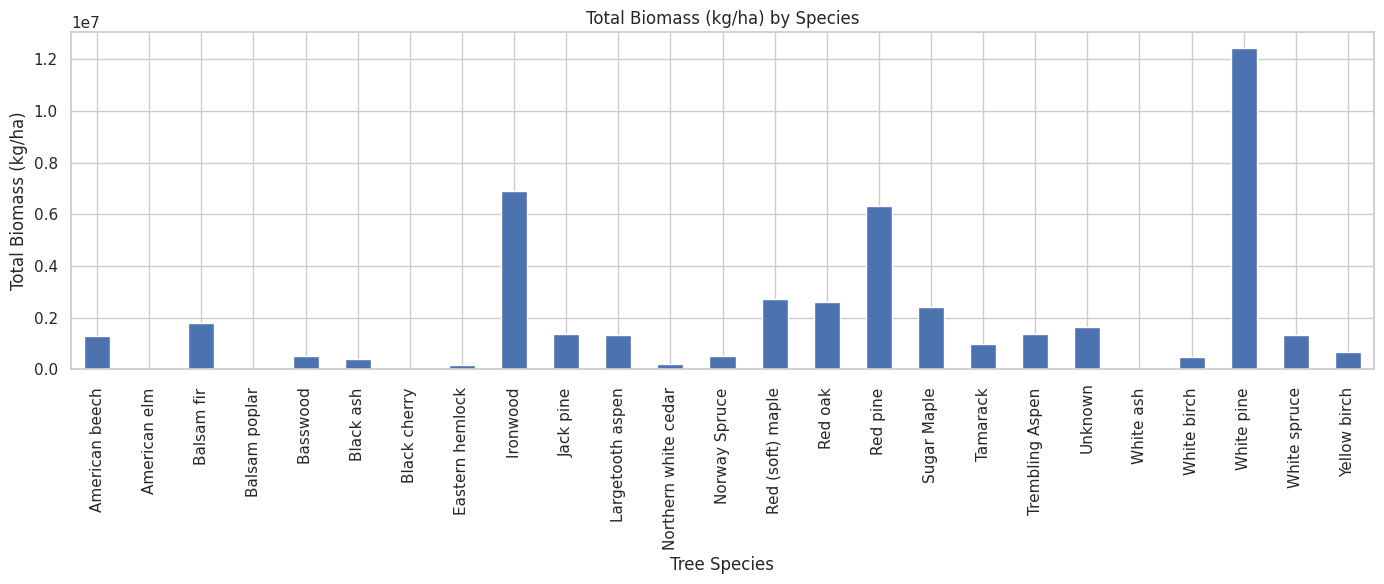

In [ ]:
#@title Solution
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))

# Group by PlotName and sum biomass for each plot
biomass_by_plot = trees_df.groupby('species')['biomass'].sum()

plt.figure(figsize=(14, 6))
biomass_by_plot.plot(kind='bar')
plt.xlabel('Tree Species')
plt.ylabel('Total Biomass (kg/ha)')
plt.title('Total Biomass (kg/ha) by Species')
plt.xticks(rotation=90, ha='center')
plt.tight_layout()
plt.show()

The general trend in the plot shows that most tree species have moderate `total biomass (kg/ha)`, but a few species stand out with much higher values. `White pine` has the highest total biomass by a large margin, followed by `Ironwood` and `Red pine`. In contrast, species like `Black cherry`, `Northern white cedar`, and `White birch` have the lowest total biomass values in the dataset. This indicates that biomass is heavily concentrated in a few dominant species, while many others contribute relatively little

# Further Steps

We save the cleaned data to a new CSV to preserve our corrections and ensure future analyses use accurate, reliable information—while keeping the original raw data unchanged for reference.

In [ ]:
# Save the DataFrame to a CSV file in the current directory
tree_df.to_csv('./data/trees_data_cleaned.csv', index=False)

## References

Perplexity AI. (2025). Responses to data analysis and visualization queries for forestry research in the Petawawa region. Retrieved from https://www.perplexity.ai